# Reinforcement Learning For Structural Evolution.
This experiement ReLeaSe has two significant parts.
## PART 1 - Use a StackRNN to transform chemical formulas for compounds into a SMILE representation, 
* SMILE is just a String ecnoding for this chemical formula that makes it easier to perform the second part of the experiment.<br>  <br>
* A StackRNN which is a variant of an RNN is used to convert any new chemical formula into the SMILE version.<br>
* An example can be seen in the 2 strings below converted from Carbon monoxide and carbon.<br>
<br>
<b>CO->CHEMBL14688</b><br>
<b>C->CHEMBL17564</b><br>
<br>
* This conversion is especially useful when regarding formulas with double and triple bonds,like below.<br>
<br>
<b>CC(O)=O->CHEMBL539</b><br>
<b>CC(N)=S</b><br>
<br>
* This property is especially useful in this use case since most of the formulas that will be modified are goingto be complex and thus a system like SMILE is used effectively.<br>
## PART 2- Training a generative and predictive model together and use reinforcement learning to bias towards desired properties in the generated compounds.
* In this part of the experiment the valid SMILE strings are fed into a LSTM (Long short term memory network).
* There will be more elaboration about this in the future since there is a lot to say.
* The graphic below is a good description of the experiment flow taken from https://github.com/isayev/ReLeaSE
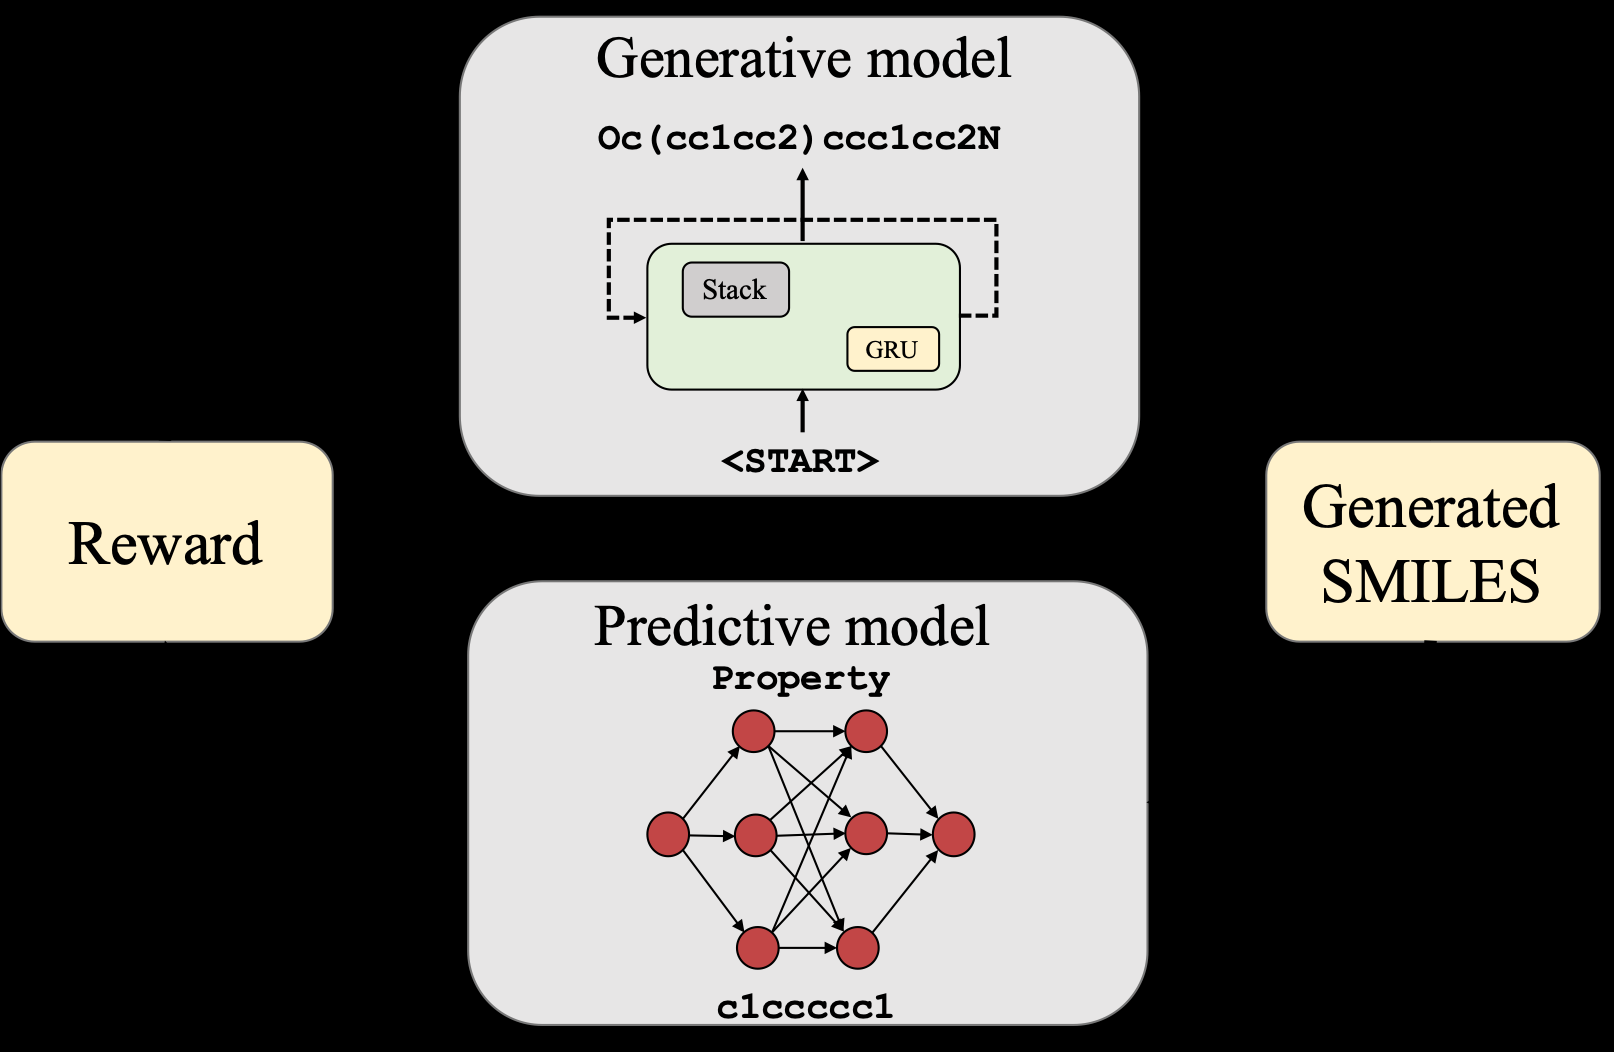

In [1]:
#Environment prep
%env CUDA_VISIBLE_DEVICES=1
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=1


In [ ]:
#Imports, libs needed
import sys
sys.path.append('./release/')
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F
use_cuda = torch.cuda.is_available()

In [ ]:
#More imports
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#DATA GENERATION, issue rn since the data set is so large that we are not able to process it wihtout kernel death
#For now we are able to avoid it by loading a pretrained model, can train in the future
#gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
#gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
 #                        cols_to_read=[0], keep_header=True, tokens=tokens)

In [ ]:
#Some Useful functions below
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.0) & 
                                     (prediction <= 5.0))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.0)
    plt.axvline(x=5.0)
    ax.set(xlabel='Predicted LogP', 
           title='Distribution of predicted LogP for generated molecules')
    plt.show()
    
def estimate_and_update(generator, predictor, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, use_tqdm=True)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

# Explaining RNN's and the StackRNN used in this case
* An RNN is a type of neural network more akin to understanding and predicting sequential information such as stock market quotes.
* This is different from convolutional Neural networks which understand spatial input better.
* In this case the RNN is tasked with taking in past mappings of chemical formulas to SMILE representations and outputting SMILEs for any future inputs.
* Processing text data as input is a popular use for RNN which is what will be done in this case, break the input into sequences of characters
* Leverages the concept of sequential memory.

## How a typical RNN works
* Activation value from previous timesteps is passed on to the next to help in the prediction, the only timestep that doesn't use previous info is timestep 1.
* Same parameters for each timestamp wax
* Same parameters passed on waa
* y3 uses x2,x1 but doesnt use x4 onwards
* 
* Each time step is a layer.
* One problem here lies in the backpropogation method where in an RNN the earlier layers essentially learn less since the weights are changed less and less as the layers go further back in time.Vanishing gradient problem1
* RNN suffer from short term memory, mitigated by use of LSTM's and GRU's but they can learn long term dependancies using gates, knowing what to add to the hidden state both long term and short term.


## How the StackRNN works
* Place

In [6]:
#Load in the pretrained StackRNN
model_path = './checkpoints/generator/checkpoint_biggest_rnn'
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=45, hidden_size=hidden_size,
                                 output_size=45, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=False, 
                                 optimizer_instance=optimizer_instance, lr=lr)
my_generator.load_model(model_path)

NameError: name 'StackAugmentedRNN' is not defined

In [7]:
#! git clone --single-branch --branch develop https://github.com/Mariewelt/OpenChem.git

In [8]:
#More env setup and imports
sys.path.append('./OpenChem/')
from rnn_predictor import RNNPredictor
predictor_tokens = tokens + [' ']
path_to_params = './checkpoints/logP/model_parameters.pkl'
path_to_checkpoint = './checkpoints/logP/fold_'

/home/araman18/anaconda3/envs/release/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/araman18/anaconda3/envs/release/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/araman18/anaconda3/envs/release/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/araman18/anaconda3/envs/release

In [11]:
#Setup the predictor
my_predictor = RNNPredictor(path_to_params, path_to_checkpoint, predictor_tokens)

[autoreload of rnn_predictor failed: Traceback (most recent call last):
  File "/home/araman18/anaconda3/envs/release/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/araman18/anaconda3/envs/release/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/araman18/anaconda3/envs/release/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/araman18/anaconda3/envs/release/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/araman18/anaconda3/envs/release/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/araman18/anaconda3/envs/release/lib/python3.6/site-packages/IPython/extension

TypeError: super(type, obj): obj must be an instance or subtype of type